# Bias - Variance

In [1]:
import pandas as pd
import math
import numpy as np
import math
import pandas as pd
import seaborn as sns
import numpy.linalg as la
import scipy.optimize as op
from scipy.stats import norm
from scipy.io import loadmat
from scipy.optimize import minimize
from matplotlib import pyplot as plt

## Load and plot data

In [2]:
data = loadmat('data/ex5data1.mat')
print('data keys:', data.keys())
Xtrain = data['X']
ytrain = data['y']
Xtest = data['Xtest']
ytest = data['ytest']
Xval = data['Xval']
yval = data['yval']

data keys: dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'Xtest', 'ytest', 'Xval', 'yval'])


In [3]:
print('Xtrain.shape:', Xtrain.shape)
print('ytrain.shape:', ytrain.shape)
print('Xtest.shape:', Xtest.shape)
print('ytest.shape:', ytest.shape)
print('XCV.shape:', Xval.shape)
print('yCV.shape:', yval.shape)

Xtrain.shape: (12, 1)
ytrain.shape: (12, 1)
Xtest.shape: (21, 1)
ytest.shape: (21, 1)
XCV.shape: (21, 1)
yCV.shape: (21, 1)


In [4]:
# Visualize the example dataset
dTrain = np.column_stack([Xtrain, ytrain])

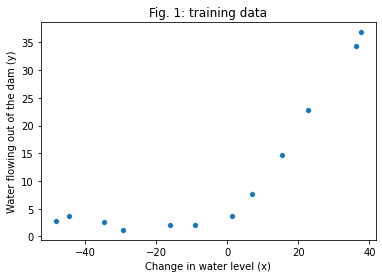

In [5]:
fig = sns.scatterplot(dTrain[:,0], dTrain[:,1])

plt.xlabel("Change in water level (x)")
plt.ylabel("Water flowing out of the dam (y)")
plt.title("Fig. 1: training data") # You can comment this line out if you don't need title
plt.show(fig)


## Fitting linear regression

In [42]:
def costFuncRegLinear(theta, X, y, lambda_):
    theta = theta.reshape([-1,1])
    m = X.shape[0] 
    J = 0.5/m * ((la.norm(X @ theta - y)) **2 + lambda_ * la.norm(theta) **2)

    grad = 1/m *((X.T @ (X @ theta - y)) + lambda_ * theta)

    return J, grad.flatten()

def f(theta, X, y, lambda_):
    return costFuncRegLinear(theta, X, y, lambda_)[0]

def fprime(theta, X, y,lambda_):
    return costFuncRegLinear(theta, X, y, lambda_)[1]

In [40]:
# Initialize theta
m = Xtrain.shape[0]
n = Xtrain.shape[1]
initial_theta = np.zeros([n+1, 1])

# add bias term
myXtrain = np.column_stack([np.ones([m,1]), Xtrain])

J = f(init_theta, myXtrain, ytrain, 1)
grad = fprime(init_theta, myXtrain, ytrain, 1)
print('Using theta initialized at [1, 1], we see an output of %f\n'% J,
     'and gradient of \n', grad)

f: theta (2, 1)
Using theta initialized at [1, 1], we see an output of 304.034859
 and gradient of 
 [-15.21968234 598.25074417]


In [125]:
op.fmin_bfgs?


In [43]:
learned_theta = op.fmin_bfgs(f = f, 
                x0 = initial_theta.flatten(), 
                fprime = fprime,
                args = (myXtrain, ytrain, 0),
                full_output=True)

Optimization terminated successfully.
         Current function value: 22.373906
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5


In [48]:
# fmin_bfgs actually calls minimize function
res = op.minimize(f, initial_theta.flatten(), args =(myXtrain, ytrain, 0), method='BFGS', tol=1e-6)

In [58]:
# Note that the results are the same
print(learned_theta[0], res['x'])

[13.08790351  0.36777923] [13.08790327  0.36777922]


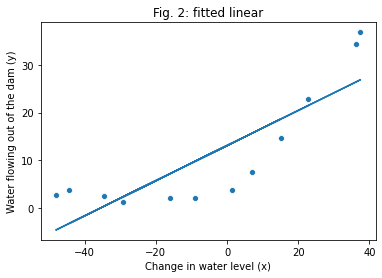

In [70]:
fig = sns.scatterplot(dTrain[:,0], dTrain[:,1])

plt.xlabel("Change in water level (x)")
plt.ylabel("Water flowing out of the dam (y)")
plt.plot(Xtrain, learned_theta[0][0] + learned_theta[0][1] * Xtrain, '-')
plt.title("Fig. 2: fitted linear") 
plt.show(fig)


## Learning curve

In [139]:
def learningCurve(X, y, Xval, yval, lambda_):
    # Generates the train and cross validation set errors needed to plot a learning curve.
    # In particular, it returns two vectors of the same length - error_train and error_val. 
    # Then, error_train[i] contains the training error for i examples (and similarly for error_val[i]).
    
    # Number of training examples
    m = X.shape[0]
    n = Xval.shape[0]

    trX = np.column_stack([X, y])
    Xval = np.column_stack([np.ones([n,1]), Xval])
    
    error_train = []
    error_val = []


    for i in range(1, m):
        # Randomly choose i examples
        
        idx = np.random.randint(m, size=i)
        
        subX = trX[idx, :]
        x_ =  np.column_stack([np.ones([i,1]), subX[:,0]])
        y_ = subX[:,1].reshape(-1,1)
        
        # Train the model
        res_theta = op.fmin_bfgs(f = f, x0 = initial_theta.flatten(), fprime = fprime,
                                 args = (x_, y_, lambda_),full_output= False)
        

        # Call cost function to get error
        err_train = f(res_theta, x_, y_, 0)
        err_cv = f(res_theta, Xval, yval, 0)
            
        error_train.append(err_train)
        error_val.append(err_cv)

    return error_train, error_val

In [140]:
error_train, error_val = learningCurve(Xtrain, ytrain, Xval, yval, lambda_=0)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 8
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.053574
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.762450
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 13.209239
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 13.445427
         Iterations: 5
         Function evaluations: 6
         Gradie

Text(0.5, 1.0, 'Figure 3: Linear regression learning curve')

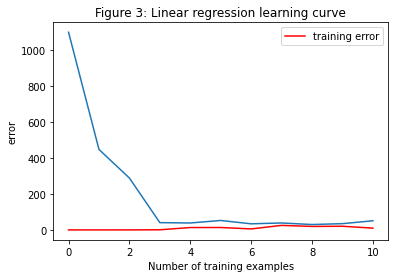

In [161]:
train = plt.plot(error_train, color = 'r', label ='training error')
cv = plt.plot(error_val, label = 'cross-validation error')
plt.legend([train, cv], handles =train)
plt.ylabel("error")
plt.xlabel('Number of training examples')
plt.title('Figure 3: Linear regression learning curve')